In [1]:
import os
import sys
import argparse
import pandas as pd
import pysam
import numpy as np
import time
from scipy.signal import savgol_filter
import yaml 
from multiprocessing import Pool

# import warnings
# warnings.filterwarnings('error')

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample specific params for testing
#ER_pos_merged:
sample_name = 'HD45.ctDNA.WGS.FC19269447'
bam_path = '/fh/scratch/delete90/ha_g/realigned_bams/cfDNA_deepWGS_hg38/deepWGS_fastq_to_bam_paired_snakemake/results/HD45.ctDNA.WGS.FC19269447/HD45.ctDNA.WGS.FC19269447_recalibrated.bam'
GC_bias_path = '/fh/fast/ha_g/user/adoebley/projects/griffin_paper/GC_correction/MBC_GC_correction/results/repeat_masker.mapable.k50.Umap.hg38/GC_bias/HD45.ctDNA.WGS.FC19269447.GC_bias.txt'
background_normalization = 'none'
ref_seq_path = '/fh/fast/ha_g/grp/reference/GRCh38/GRCh38.fa'

# #additional params for testing
sites_yaml = 'test_sites.yaml'
results_dir = 'results/'

chrom_col = 'Chrom'
chroms = ['chr'+str(m) for m in np.arange(1,23)]
norm_window = [-5000, 5000] #for testing
plot_window = [-1000, 1000]#for testing
fragment_length = 165

step = 15
sz_range = [100, 200]
map_q = 20
strand_col = 'Strand'

individual = 'False'
smoothing = 'True'

number_of_sites = 'none'
sort_by = 'none'
ascending = 'none'

CPU = 4

debugging = True

In [3]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--sample_name', help='name of sample', required=True)
# parser.add_argument('--bam', help='bam file', required=True)
# parser.add_argument('--GC_bias', help='GC bias info', required=True)
# parser.add_argument('--background_normalization', help='None or local', required=True)
# parser.add_argument('--reference_genome',help = 'path to the reference genome',required=True)

# parser.add_argument('--sites_yaml', help='.bed file of sites', required=True)
# parser.add_argument('--results_dir', help='directory for coverage_data', required=True)

# parser.add_argument('--chrom_column',help='name of column containing chromosome number', default='Chrom')
# parser.add_argument('--chroms', help='chroms to include when selecting sites', nargs='*', default=['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'])
# parser.add_argument('--norm_window',help='start and end of the window to be used for normalization',nargs=2, type=int, default=(-5000,5000))
# parser.add_argument('--plot_window',help='start and end of window to be plotted',nargs=2, type=int, default=(-1000,1000))
# parser.add_argument('--fragment_length',help='length of fragment (in bp) for which GC will be calculated, default 165',type=int, default=165)

# parser.add_argument('--step',help='step size when calculating coverage', type=int, default=5)
# parser.add_argument('--size_range',help='acceptable size range for fragments (to filter out genomic contamination)',nargs=2, type=int, default=(0,500))
# parser.add_argument('--map_quality',help='minimum mapping quality', type=int, default=60)
# parser.add_argument('--strand_column',help='name of column containing the strand (+ or -)', default='Strand')

# parser.add_argument('--individual',help='save individual site coverage. TRUE WILL RESULT IN HUGE OUTPUT FILES. (True/False)',default='False', required = True)
# parser.add_argument('--smoothing',help='whether to use a savgol filter to smooth sites (True/False)', required = True)

# parser.add_argument('--num_sites',help='number of sites to analyze', default='NA')
# parser.add_argument('--sort_by',help='how to select the sites to analyze', default='none')
# parser.add_argument('--ascending',help='whether to sort in ascending or descending order when selecting sites', default='NA')

# parser.add_argument('--cpu',help='cpu available for parallelizing', type = int, required = True)


# args = parser.parse_args()


# sample_name=args.sample_name
# bam_path=args.bam
# GC_bias_path=args.GC_bias
# background_normalization = args.background_normalization
# ref_seq_path = args.reference_genome

# sites_yaml=args.sites_yaml
# results_dir=args.results_dir

# chrom_col=args.chrom_column
# chroms = args.chroms
# norm_window =args.norm_window
# plot_window=args.plot_window
# fragment_length=args.fragment_length

# step=args.step
# sz_range=args.size_range
# map_q=args.map_quality
# strand_col=args.strand_column

# individual=args.individual
# smoothing = args.smoothing

# number_of_sites=args.num_sites
# sort_by=args.sort_by
# ascending=args.ascending

# CPU = args.cpu

# debugging = False

In [4]:
if ascending.lower()=='false':
    ascending=False
elif ascending.lower()=='true':
    ascending=True
else:
    ascending='none'

print('\narguments provided:')

print('\tsample_name = "'+sample_name+'"')
print('\tbam_path = "'+bam_path+'"')
print('\tGC_bias_path = "'+GC_bias_path+'"')
print('\tbackground_normalization = "'+background_normalization+'"')
print('\tref_seq_path = "'+ref_seq_path+'"')
#print('\ttumor_fraction =',tumor_fraction)

print('\tsites_yaml = "'+sites_yaml+'"')
print('\tresults_dir = "'+results_dir+'"')

print('\tchrom_col = "'+chrom_col+'"')
print('\tchroms = ',chroms)
print('\tnorm_window = ', norm_window)
norm_window=[int(np.ceil(norm_window[0]/step)*step),int(np.floor(norm_window[1]/step)*step)] #round to the nearest step inside the window
print('\t#norm_window rounded to step',norm_window)
print('\tplot_window = '+str(plot_window))
plot_window=[int(np.ceil(plot_window[0]/step)*step),int(np.floor(plot_window[1]/step)*step)] #round to the nearest step inside the window
print('\t#plot_window rounded to step:',plot_window)
print('\tfragment_length =',fragment_length)
fragment_length=int(np.ceil(fragment_length/step)*step) #round fragment length to the nearest step
print('\t#fragment_length_rounded_up_to_step:',fragment_length)

print('\tstep =',step)
print('\tsz_range =',sz_range)
print('\tmap_q =',map_q)
print('\tstrand_col = "'+strand_col+'"')

print('\tindividual = "'+individual+'"')
if smoothing.lower()=='true' or smoothing.lower()=='false':
    print('\tsmoothing = "'+smoothing+'"')
else:
    print('smoothing must be True or False! :',smoothing)
    sys.exit()

print('\tnumber_of_sites = "'+str(number_of_sites)+'"')
print('\tsort_by = "'+sort_by+'"')
print('\tascending = "'+str(ascending)+'"')

print('\tCPU =',CPU)
print('\n')
sys.stdout.flush()


arguments provided:
	sample_name = "HD45.ctDNA.WGS.FC19269447"
	bam_path = "/fh/scratch/delete90/ha_g/realigned_bams/cfDNA_deepWGS_hg38/deepWGS_fastq_to_bam_paired_snakemake/results/HD45.ctDNA.WGS.FC19269447/HD45.ctDNA.WGS.FC19269447_recalibrated.bam"
	GC_bias_path = "/fh/fast/ha_g/user/adoebley/projects/griffin_paper/GC_correction/MBC_GC_correction/results/repeat_masker.mapable.k50.Umap.hg38/GC_bias/HD45.ctDNA.WGS.FC19269447.GC_bias.txt"
	background_normalization = "none"
	ref_seq_path = "/fh/fast/ha_g/grp/reference/GRCh38/GRCh38.fa"
	sites_yaml = "test_sites.yaml"
	results_dir = "results/"
	chrom_col = "Chrom"
	chroms =  ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']
	norm_window =  [-5000, 5000]
	#norm_window rounded to step [-4995, 4995]
	plot_window = [-1000, 1000]
	#plot_window rounded to step: [-990, 990]
	fragment_length = 165
	#fragmen

In [5]:
#define global parameters and open global files

#set up global variables
norm_columns = np.arange(norm_window[0],norm_window[1],step)
plot_columns = np.arange(plot_window[0],plot_window[1],step)

# #import the site files
with open(sites_yaml,'r') as f:
    site_files = yaml.safe_load(f)
site_files = site_files['site_files']
site_files = [[key,site_files[key]] for key in site_files.keys()]
to_do_list = site_files

########################################
#GET GC BIAS
########################################
#open the GC_bias file 
GC_bias = pd.read_csv(GC_bias_path, sep='\t')

#get rid of extremely low GC bias values
#these fragments will now be excluded 
#these fragments are extremely rare so it is difficult to get a good estimate of GC bias
GC_bias['smoothed_GC_bias'] = np.where(GC_bias['smoothed_GC_bias']<0.05,np.nan,GC_bias['smoothed_GC_bias'])

GC_bias = GC_bias[['length','num_GC','smoothed_GC_bias']]
GC_bias = GC_bias.set_index(['num_GC','length']).unstack()

#convert to a dictionary
GC_bias = GC_bias.to_dict()

#get rid of values where the num_GC is greater than the length (included due to the way I made the dict)
GC_bias2 = {}
for key in GC_bias.keys():
    length = key[1]
    GC_bias2[length] = {}
    for num_GC in range(0,length+1):
        bias = GC_bias[key][num_GC]
        GC_bias2[length][num_GC]=bias
GC_bias = GC_bias2 
del(GC_bias2)

step_1_import_sites

In [6]:
def step_1_import_sites(sites_file,site_name): #number of sites needed so it can be changed to an int
    all_sites=pd.read_csv(sites_file,sep='\t')
    print(site_name,'total sites',len(all_sites))
    
    #throw out sites that aren't on the selected chroms
    all_sites = all_sites[all_sites[chrom_col].isin(chroms)]
    print(site_name,'sites on selected chromosomes',len(all_sites))
    
    #select the sites to use if specified
    if sort_by.lower()=='none': #if using all sites 
        print(site_name,'processing all '+str(len(all_sites))+' sites')
    
    else: #othewise sort by the specified column
        print(site_name,'sorting by',sort_by,'and selecting the top',number_of_sites,',ascending:',ascending)
        print(site_name,sort_by,'initial range: ',min(all_sites[sort_by]),'to',max(all_sites[sort_by]))
        all_sites=all_sites.sort_values(by=sort_by,ascending=ascending).reset_index(drop=True)#sort and reset index
        all_sites=all_sites.iloc[0:int(number_of_sites)]
        print(site_name,sort_by,'range after sorting: ',min(all_sites[sort_by]),'to',max(all_sites[sort_by]))

    #add a site_name column
    all_sites['site_name']=site_name
    #add a sample column
    all_sites['sample']=sample_name
    #add background normalizatino
    all_sites['background_normalization']=background_normalization
    
    #split the list of all sites into groups for quicker processing
    max_chunk_size=500
    n_chunks=np.ceil(len(all_sites)/max_chunk_size)
    site_groups=np.array_split(all_sites.index.values,n_chunks)
    
    return(all_sites, site_groups)


step_2_collect_coverage

In [7]:
def collect_fragments(sites,window_start,window_end,direction):
    #open the bam file for each pool worker (otherwise individual pool workers can close it)
    bam_file = pysam.AlignmentFile(bam_path)
    
    #open the ref seq
    ref_seq=pysam.FastaFile(ref_seq_path)

    #extend the window by half the max fragment length in each direction
    max_adjustment = np.int(np.ceil(sz_range[1]/2))
    adjusted_start = window_start-max_adjustment
    adjusted_end = window_end+max_adjustment
    
    window_columns = np.arange(window_start,window_end,step)
    
    #make sure Chrom is a string
    sites[chrom_col]=sites[chrom_col].astype(str)
            
    cov_pd={} #set up dictionary to hold data
    GC_cov_pd = {} #set up a dictionary to hold GC corrected data


    for endpoint in ['start','end']:
        cov_pd[endpoint]=pd.DataFrame(columns = window_columns)
        GC_cov_pd[endpoint] = pd.DataFrame(columns = window_columns)
        
    #workaround for NCBI style formatted bams (1,2,3 etc) with UCSC sites
    if len(sites)>0:
        test_chrom=sites.iloc[0][chrom_col]
        try:
            bam_file.get_reference_length(test_chrom)
            NCBI=False
        except:
            bam_file.get_reference_length(test_chrom.split('chr')[-1])
            NCBI=True
     
    #run analysis on each site
    for i in range(len(sites)): #for each location in the genome
        if i%100==0: 
            print (sites.iloc[0]['site_name'],i,time.time()-start_time)
            sys.stdout.flush()

        #############
        #make dicts to hold output for this individual site
        #############
        #for now, catch all reads that start or end within a fragment length of the window
        cov_dict = {}
        GC_cov_dict = {}
        for item in ['start','end']:
            cov_dict[item]={m:0 for m in range(adjusted_start,adjusted_end)} 
            GC_cov_dict[item]={m:0 for m in range(adjusted_start,adjusted_end)} 
                
        ####################
        #fetch reads
        ####################
        #identify the analysis window for that site
        chrom = sites.iloc[i][chrom_col]
        position = sites.iloc[i]['position']
        
        if NCBI:
            chrom=chrom.split('chr')[-1]
                    
        #these regions have been filtered so they should all be fetchable
        fetched=bam_file.fetch(contig=chrom, start=adjusted_start+position, stop=adjusted_end+position) #fetch reads that map to the region of interest
        
        ########################
        #count coverage
        ########################
        for read in fetched:
            #filter out reads
            if abs(read.template_length)>=sz_range[0] and abs(read.template_length)<=sz_range[1] \
            and read.is_paired==True and read.mapping_quality>=map_q and read.is_duplicate==False and read.is_qcfail==False:
                read_start=read.reference_start-position #read start (with respect to the position of the current region of interest)
                
                #find the place where the fragment starts or ends with respect to the window
                if read.is_reverse==False and read.template_length>0:
                    fragment_start = read_start
                    fragment_end = read_start+read.template_length
                    read_type='start'
                    
                    #adjusted_loc = fragment_start+int(np.ceil(fragment_length/2)) #where to count the coverage
                    midpoint = int(np.floor((fragment_start+fragment_end)/2))
                                        
                elif read.is_reverse==True and read.template_length<0:
                    read_len=read.reference_length #this is the read length only (for adjusting the start position)
                    fragment_start = read_start+read_len+read.template_length
                    fragment_end = read_start+read_len
                    read_type='end'
                    
                    #adjusted_loc = fragment_end-int(np.ceil(fragment_length/2)) #where to count the coverage
                    midpoint = int(np.floor((fragment_start+fragment_end)/2))
                           
                else:
                    continue
                    
                #get the fragment seq for GC content
                #seq_string = (ref_seq.fetch(chrom,fragment_start+position,fragment_end+position)).upper() #for printing
                
                fragment_seq = (ref_seq.fetch(chrom,fragment_start+position,fragment_end+position)).upper()
                fragment_seq = list(fragment_seq.replace('T','0').replace('A','0').replace('C','1').replace('G','1').replace('N',str(np.random.randint(0,2))))
                fragment_seq = [int(m) for m in fragment_seq]
                
                ##check work
                ############
                #print(read_type,read.query_sequence)
                #if read.is_reverse == False:
                #    print(read_type,seq_string[0:read.reference_length])
                #elif read.is_reverse == True:
                #    print(read_type,seq_string[-read.reference_length:])
                #print(sum(fragment_seq),len(fragment_seq),read.template_length)
                #print('\n')
                ###########
                
                #check that the site is in the window          
                if midpoint>=adjusted_start and midpoint<adjusted_end:
                    #count the fragment
                    cov_dict[read_type][midpoint]+=1
                    
                    ##get the GC bias
                    read_GC_content = sum(fragment_seq)
                    read_GC_bias = GC_bias[abs(read.template_length)][read_GC_content]
                    
                    #count the fragment weighted by GC bias
                    if not np.isnan(read_GC_bias):
                        GC_cov_dict[read_type][midpoint]+=(1/read_GC_bias)
   
                else: #if fragment doesn't fully overlap
                    continue
            
                del(read,midpoint,read_type)
            
        ###########################      
        #after counting all reads at that site
        ###########################
        for endpoint in ['start','end']:
            cov_list = np.array([cov_dict[endpoint][m] for m in range(window_start,window_end)])
            cov_list = np.sum(cov_list.reshape(-1, step), axis=1) #take the sum of every step
            cov_list = pd.Series(cov_list, index = window_columns, name=sites.iloc[i].name) #convert to pandas series
            cov_pd[endpoint]=cov_pd[endpoint].append(cov_list)
            GC_cov_list=np.array([GC_cov_dict[endpoint][m] for m in range(window_start,window_end)])
            GC_cov_list=np.sum(GC_cov_list.reshape(-1, step), axis=1) #take the sum of every 5(step) bp
            GC_cov_list = pd.Series(GC_cov_list, index = window_columns, name=sites.iloc[i].name) #convert to pandas series
            GC_cov_pd[endpoint]=GC_cov_pd[endpoint].append(GC_cov_list)

    #put into the same format as the output data
    out_dict = {}
    for data_type in ['reads','GC_corr']:
        out_dict[data_type]={}
        for endpoint in ['start','end']:
            out_dict[data_type][endpoint]={}    
    
    for endpoint in ['start','end']:
        out_dict['reads'][endpoint][direction] = cov_pd[endpoint]
        out_dict['GC_corr'][endpoint][direction] = GC_cov_pd[endpoint]
        
    return(out_dict)


run full analysis

In [8]:
def run_full_analysis(input_items):
    site_name,site_file = input_items

    #############################################
    #check whether the output files already exist
    #############################################
    current_out_file=results_dir+'/'+sample_name+'.'+site_name+'.midpoint_coverage.txt'
    if os.path.exists(current_out_file):
        print('done',site_name)
        return('done')
    else: #if any file is incomplete
        print('analyzing:',site_name)

    #make any necessary directorys for output
#     try: 
#         os.mkdir(results_dir+'/coverage/'+site_name)
#         print('output directory created:',results_dir+'/coverage/'+site_name)
#     except:
#         print('output directory already exists:',results_dir+'/coverage/'+site_name)
#         pass

    ############
    #set up#####
    ############
    all_sites,site_groups = step_1_import_sites(site_file,site_name)


    #set up structure for output
    out_data = {}
    for data_type in ['reads','GC_corr']:
        out_data[data_type]={}
        for endpoint in ['start','end']:
            out_data[data_type][endpoint]={}
            for direction in ['fw','rv']:#site direction
                    out_data[data_type][endpoint][direction]=pd.DataFrame()

    ################################
    #process each group of sites####
    ################################ 
    for group in site_groups:           
        sites=all_sites.loc[group].copy() #get the sites at the specified indexes

        print(site_name,'processing sites:',sites.index.values[0],'to',sites.index.values[-1])
        sys.stdout.flush()

        #if site direction is specified, split fw and rv sites
        if strand_col in sites.columns:
            fw_sites=sites[~(sites[strand_col]=='-')].copy() #include non-specified sites
            rv_sites=sites[sites[strand_col]=='-'].copy()
            print(site_name,'fw,rv',len(fw_sites),len(rv_sites))
        else: #if direction isn't specified, put all sites into fw sites
            fw_sites = sites.copy()
            rv_sites = pd.DataFrame(columns = sites.columns)

        current_fw_data = collect_fragments(fw_sites,norm_window[0],norm_window[1],'fw')
        current_rv_data = collect_fragments(rv_sites,norm_window[1]*-1,norm_window[0]*-1,'rv')

        #merge current fw data into data frame
        for data_type in ['reads','GC_corr']:
            for endpoint in ['start','end']:
                out_data[data_type][endpoint]['fw'] = out_data[data_type][endpoint]['fw'].append(current_fw_data[data_type][endpoint]['fw'])

        #merge current rv data into data frame
        for data_type in ['reads','GC_corr']:
            for endpoint in ['start','end']:
                out_data[data_type][endpoint]['rv'] = out_data[data_type][endpoint]['rv'].append(current_rv_data[data_type][endpoint]['rv'])

    #flip the reverse sites
    print(site_name,'flipping reverse sites')
    sys.stdout.flush()

    for data_type in ['reads','GC_corr']:
        for endpoint in ['start','end']:
            new_columns = (out_data[data_type][endpoint]['rv'].columns*-1)-step
            out_data[data_type][endpoint]['rv'].columns = new_columns
            out_data[data_type][endpoint]['rv']=out_data[data_type][endpoint]['rv'][np.sort(new_columns)]
        out_data[data_type]['start']['rv'],out_data[data_type]['end']['rv'] = out_data[data_type]['end']['rv'],out_data[data_type]['start']['rv']

    #merge fw and rv sites into a single data frame
    for data_type in ['reads','GC_corr']:
        for endpoint in ['start','end']:
            out_data[data_type][endpoint] = out_data[data_type][endpoint]['fw'].append(out_data[data_type][endpoint]['rv']) 
            #sort them back into the original order
            out_data[data_type][endpoint] = out_data[data_type][endpoint].sort_index()

    #get the total reads per site
    start_total_reads = out_data['reads']['start'].sum(axis=1)
    end_total_reads = out_data['reads']['end'].sum(axis=1)
    GC_start_total_reads = out_data['GC_corr']['start'].sum(axis=1)
    GC_end_total_reads = out_data['GC_corr']['end'].sum(axis=1)

    #add to metadata data frame
    all_sites['total_read_starts'] = start_total_reads
    all_sites['total_read_ends'] = end_total_reads 
    all_sites['GC_corrected_total_read_starts'] = GC_start_total_reads
    all_sites['GC_corrected_total_read_ends'] = GC_end_total_reads
    
    #normalize the average site to 1
    for data_type in ['reads','GC_corr']:
        for endpoint in ['start','end']:
            #i'm not sure why this if statement is in here, not going to delete it quite yet
            #if len(out_data[data_type][endpoint])>0:
            #take the means (ignore nans)
            mean_value = np.nanmean(out_data[data_type][endpoint].astype(float).values) 
            #normalize to 1 for an average site 
            out_data[data_type][endpoint] = out_data[data_type][endpoint]/mean_value

    #normalize individual sites to 1 if background_normalization == 'local'
    if background_normalization == 'local':
        print(site_name,'normalizing individual sites to one')
        for data_type in ['reads','GC_corr']:
            for endpoint in ['start','end']:
                mean_data = out_data[data_type][endpoint].values.mean(axis=1,keepdims=True)
                #replace zero with nan
                mean_data = np.where(mean_data==0,np.nan,mean_data)
                out_data[data_type][endpoint] = out_data[data_type][endpoint]/mean_data
    

    #if not saving individual sites, take the mean
    if individual.lower()=='false':
        print(site_name,'taking means')
        for data_type in ['reads','GC_corr']:
            for endpoint in ['start','end']:
                #not sure why 'astype' is needed but it seems to be required    
                #number of sites will be the same for all data types and endpoints        
                number_of_sites_used = len(out_data[data_type][endpoint][~(np.isnan(out_data[data_type][endpoint].values.mean(axis=1).astype(float)))])
                            
                out_data[data_type][endpoint] = out_data[data_type][endpoint].mean(axis=0)
                #convert back to dataframe for further processing
                out_data[data_type][endpoint] = pd.DataFrame(out_data[data_type][endpoint]).T
        print(site_name,'mean of',number_of_sites_used, 'sites')

    #################
    #smooth data
    #################
    if smoothing.lower()=='true':
        #savgol window should be approx one fragment length but it must be odd
        savgol_window=np.floor(fragment_length/step)
        if savgol_window%2==0:
            savgol_window=savgol_window+1
        savgol_window=int(savgol_window)

        print(site_name,'smoothing')
        sys.stdout.flush()

        for data_type in ['reads','GC_corr']:
            for endpoint in ['start','end']:
                out_data[data_type][endpoint][norm_columns]=savgol_filter(out_data[data_type][endpoint][norm_columns], savgol_window, 3)
    #################

    #keep only the plotting columns
    for data_type in ['reads','GC_corr']:
        out_data[data_type]['start'] = out_data[data_type]['start'][plot_columns]
        out_data[data_type]['end'] = out_data[data_type]['end'][plot_columns]


    #if taking the mean of all sites, get metadata for a mean site
    if individual.lower()=='false':
        print(site_name,'taking metadata means')
        metadata = pd.DataFrame(all_sites.iloc[0][['site_name','sample','background_normalization']]).T
        metadata['total_read_starts'] = np.mean(all_sites['total_read_starts'])
        metadata['total_read_ends'] = np.mean(all_sites['total_read_ends'])
        metadata['GC_corrected_total_read_starts'] = np.mean(all_sites['GC_corrected_total_read_starts'])
        metadata['GC_corrected_total_read_ends'] = np.mean(all_sites['GC_corrected_total_read_ends'])
        metadata['number_of_sites'] = number_of_sites_used
        all_sites = metadata

    #merge all the different dataframes
    final_data = pd.DataFrame()
    for data_type in ['reads','GC_corr']:
        for endpoint in ['start','end']:
            current_data = all_sites.merge(out_data[data_type][endpoint], left_index=True ,right_index=True)

            if data_type == 'GC_corr':
                current_data['GC_correction']='GC_corrected'
            elif data_type == 'reads':
                current_data['GC_correction']='none'
            current_data['endpoint']=endpoint

            final_data = final_data.append(current_data,ignore_index=True, sort=True)


    #rearrange the columns back into a logical order
    metadata_columns = list(all_sites.columns) + ['GC_correction','endpoint']

    final_data = final_data[metadata_columns+list(plot_columns)]

    #start and end traces should be nearly the same (because they are being used to calculate midpoints)
    #keep only start for export
    final_data = final_data[final_data['endpoint']=='start']
    final_data['endpoint']='midpoint'
    
    #export
    print(site_name,'exporting')
    sys.stdout.flush()
    final_data.to_csv(current_out_file,sep='\t',float_format='%.5f', index=False)
    
    print('done',site_name)
    sys.stdout.flush()
    
    if debugging == True:
        print('debugging!')
        return(final_data)
    elif debugging == False:
        pass

In [9]:
#cell for testing
#start the timer
start_time=time.time()

#for testing use a single CPU
for item in to_do_list:
    final_data=run_full_analysis(item)


analyzing: LYL1.hg38
LYL1.hg38 total sites 10000
LYL1.hg38 sites on selected chromosomes 10000
LYL1.hg38 processing all 10000 sites
LYL1.hg38 processing sites: 0 to 499
LYL1.hg38 0 0.31997156143188477
LYL1.hg38 100 30.56232190132141
LYL1.hg38 200 56.18216872215271
LYL1.hg38 300 86.20021605491638
LYL1.hg38 400 113.16256380081177
LYL1.hg38 processing sites: 500 to 999
LYL1.hg38 0 143.1016345024109
LYL1.hg38 100 172.58060574531555
LYL1.hg38 200 199.00035333633423
LYL1.hg38 300 227.70034074783325
LYL1.hg38 400 256.42046070098877
LYL1.hg38 processing sites: 1000 to 1499
LYL1.hg38 0 297.39291644096375
LYL1.hg38 100 325.39811611175537
LYL1.hg38 200 353.70874094963074
LYL1.hg38 300 378.06776332855225
LYL1.hg38 400 405.900897026062
LYL1.hg38 processing sites: 1500 to 1999
LYL1.hg38 0 430.5356812477112
LYL1.hg38 100 454.8881573677063
LYL1.hg38 200 480.9410512447357
LYL1.hg38 300 507.8558406829834
LYL1.hg38 400 530.5383937358856
LYL1.hg38 processing sites: 2000 to 2499
LYL1.hg38 0 555.10999345779

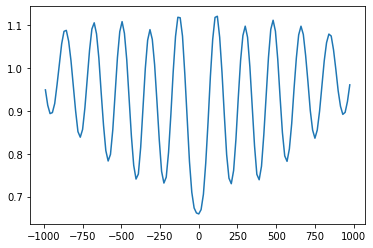

In [10]:
##plot for testing
current = final_data[(final_data['endpoint']=='midpoint') & (final_data['GC_correction']=='GC_corrected')][plot_columns].mean()
plt.plot(plot_columns,current)


In [11]:
# #run the analysis 

# #start the timer
# start_time=time.time()

# p = Pool(processes=CPU) #use the specified number of processes
# p.map(run_full_analysis, to_do_list, 1) #run the analysis on all TFs in TFs_list. Send only one item to each processor at a time.


In [12]:
# print('merging all sites')
# start_time = time.time()

# # merge results together and export
# merged_out_file = results_dir+'/coverage/all_sites/'+sample_name+'.all_sites.coverage.txt'
# try: #make any necessary directorys for output
#     os.mkdir(results_dir+'/coverage/all_sites')
# except:
#     pass 
# merged_output=pd.DataFrame()
# for j,line in enumerate(to_do_list):
#     if j%50 == 0:
#         print(line[0],time.time()-start_time)
#         sys.stdout.flush()
#     site_name = line[0]
#     indiv_out_file = results_dir+'/coverage/'+site_name+'/'+sample_name+'.'+site_name+'.coverage.txt'
#     current_data = pd.read_csv(indiv_out_file,sep='\t')
#     merged_output = merged_output.append(current_data,ignore_index=True,sort=True)

# merged_output.columns
# merged_output.to_csv(merged_out_file,sep='\t',index=False)
        
# print('done with merge')